# Intro

### Migration guild
* https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/documentintelligence/azure-ai-documentintelligence/MIGRATION_GUIDE.md

In [1]:
from dotenv import load_dotenv
load_dotenv("./envs/aisvcs.env")

True

#### Parse the full text if PDF is an image

In [2]:
# from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.ai.documentintelligence import DocumentIntelligenceClient
# from azure.ai.documentintelligence.models import AnalyzeDocumentRequest, DocumentContentFormat, AnalyzedDocument
from azure.core.credentials import AzureKeyCredential
import os
from PIL import Image
import requests

In [3]:
doc_url = "https://arxiv.org/pdf/2104.11892"

input_data_dirpath = os.path.join(os.getcwd(), "data")
input_doc_path = os.path.join(input_data_dirpath, "doc.pdf")

# download the document to the input data directory
os.makedirs(input_data_dirpath, exist_ok=True)

# download the document with requests lib to the input data directory
response = requests.get(doc_url)
with open(input_doc_path, "wb") as f:
    f.write(response.content)



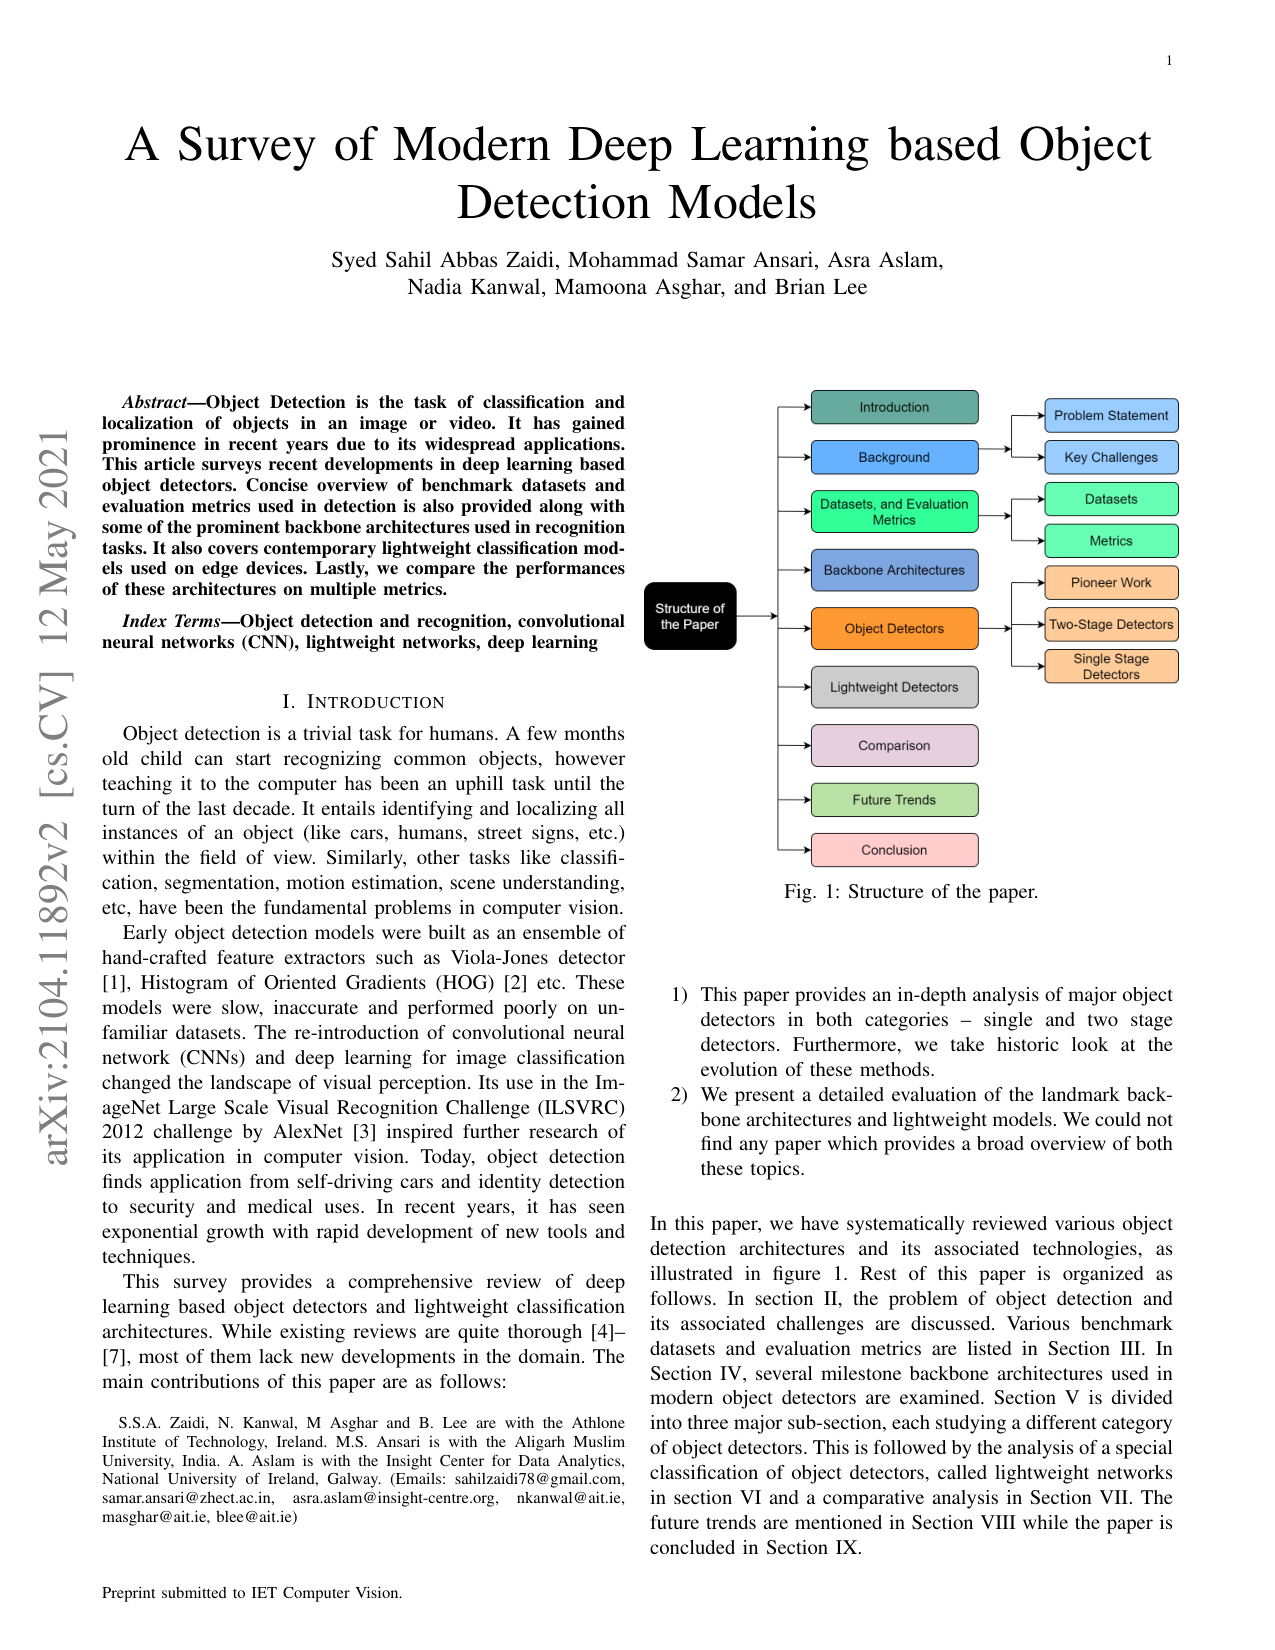

In [4]:
import base64
import pymupdf # fitz #PyMuPDF

# Open the PDF file
pdf_doc = pymupdf.open(input_doc_path)
# Select the page you want to convert (0-indexed)
page = pdf_doc.load_page(0)
# Render the page to an image
pix = page.get_pixmap(dpi=150)
converted_img_path = os.path.join(input_data_dirpath, "page1.png")
pix.save(converted_img_path)

with open(converted_img_path, "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode("utf-8")

converted_img = Image.open(converted_img_path)
display(converted_img)

In [5]:
azure_doc_intelligence_endpoint = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
doc_intelligence_key = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

client = DocumentIntelligenceClient(azure_doc_intelligence_endpoint, AzureKeyCredential(doc_intelligence_key))

# input_data_dirpath = os.path.join(os.getcwd(), "data")#insertpath of page_1.pdf here
# input_page_filepath = os.path.join(input_data_dirpath, "page_1.pdf")#insertpath of page_1.pdf here
# print(input_filepath)
input_page_filepath = converted_img_path
with open(input_page_filepath, "rb") as doc_stream:
    poller = client.begin_analyze_document("prebuilt-layout", body=doc_stream)
    # document = doc_stream.read()
    # poller = client.begin_analyze_document("prebuilt-layout", body=document)

result = poller.result()

full_text = ""
for page in result.pages:
    for line in page.lines:
        full_text += line.content + "\n"

print(full_text)

1
A Survey of Modern Deep Learning based Object
Detection Models
Syed Sahil Abbas Zaidi, Mohammad Samar Ansari, Asra Aslam,
Nadia Kanwal, Mamoona Asghar, and Brian Lee
arXiv:2104.11892v2 [cs.CV] 12 May 2021
Abstract-Object Detection is the task of classification and
localization of objects in an image or video. It has gained
prominence in recent years due to its widespread applications.
This article surveys recent developments in deep learning based
object detectors. Concise overview of benchmark datasets and
evaluation metrics used in detection is also provided along with
some of the prominent backbone architectures used in recognition
tasks. It also covers contemporary lightweight classification mod-
els used on edge devices. Lastly, we compare the performances
of these architectures on multiple metrics.
Index Terms-Object detection and recognition, convolutional
neural networks (CNN), lightweight networks, deep learning
I. INTRODUCTION
Object detection is a trivial task for humans. 

In [6]:
from openai import AzureOpenAI

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
)


prompt = """You are an intelligent document analyst.
Given this document page, identify all images, figures or tables.
For each figure:
1. Provide a detailed description of what the figure or image shows.
2. For the location just provide what the next few lines of text say, be precise (at least 2 sentences)!. If you cant find sentences afterwards (if the figure is at the end of the page) provide the previous sentences.

Just return the structured list for each image/figure/table based on what you found ALWAYS use this structure:
[Description:...
Location:...]
."""


response = client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_DEPLOYMENT"),
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
            ]
        }
    ],
    max_tokens=1000
)

anchor_text = response.choices[0].message.content

print(anchor_text)
# print(response.choices[0].message.content)

1. [Description: A flowchart illustrating the structure of the paper. It includes sections such as Introduction, Background, Datasets and Evaluation Metrics, Backbone Architectures, Object Detectors, Lightweight Detectors, Comparison, Future Trends, and Conclusion. Each section is linked to subtopics such as Problem Statement, Key Challenges, Datasets, Metrics, Pioneer Work, Two-Stage Detectors, and Single Stage Detectors.]
   [Location: "This paper provides an in-depth analysis of major object detectors in both categories – single and two stage detectors. Furthermore, we take historic look at the evolution of these methods."]


In [7]:
print(type(anchor_text))

<class 'str'>


### Insert the Chart Caption and description before the Anchor text of original chart

In [8]:

prompt = f"""You are a document editor.

Given a full document and a block of sentences that appear shortly after a figure, your job is to find where in the document these sentences appear or match most closely, and insert the following figure description **just before** them.
Respond with the new version of the document that has the description inserted in the correct place.
Insert the figure description and add **Figure description** before it.
---

Figure Description and Location:
{anchor_text}

---

Document:
{full_text}
."""

response = client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_DEPLOYMENT"),
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt}
            ]
        }
    ],
    max_tokens=2000 # increase from 1k to 2k so that the full text is not cut off
)

full_symbolic_text = response.choices[0].message.content

print(full_symbolic_text)
# print(response.choices[0].message.content)

Here is the updated document with the figure description inserted in the correct place:

---

1  
A Survey of Modern Deep Learning based Object  
Detection Models  
Syed Sahil Abbas Zaidi, Mohammad Samar Ansari, Asra Aslam,  
Nadia Kanwal, Mamoona Asghar, and Brian Lee  
arXiv:2104.11892v2 [cs.CV] 12 May 2021  
Abstract-Object Detection is the task of classification and  
localization of objects in an image or video. It has gained  
prominence in recent years due to its widespread applications.  
This article surveys recent developments in deep learning based  
object detectors. Concise overview of benchmark datasets and  
evaluation metrics used in detection is also provided along with  
some of the prominent backbone architectures used in recognition  
tasks. It also covers contemporary lightweight classification mod-  
els used on edge devices. Lastly, we compare the performances  
of these architectures on multiple metrics.  
Index Terms-Object detection and recognition, convolutio

In [9]:
print(type(full_symbolic_text))

<class 'str'>


In [10]:
anchor_text.split("Location")[1]

': "This paper provides an in-depth analysis of major object detectors in both categories – single and two stage detectors. Furthermore, we take historic look at the evolution of these methods."]'

In [11]:
#cut out figure from image
import requests
import time
from PIL import Image
from difflib import SequenceMatcher
import os

AZURE_CV_ENDPOINT = os.getenv("AZURE_CV_ENDPOINT")
AZURE_CV_KEY = os.getenv("AZURE_CV_KEY")
IMAGE_PATH = converted_img_path #"page1.png"

# The location of the figure in the document
#to make generic extract the location from the result from first analysis
# gpt_location = """
# 1) This paper provides an in-depth analysis of major object detectors in both categories single and two stage detectors. Furthermore, we take historic look to the evolution of these methods.
# 2) We present a detailed evaluation of the landmark backbone architectures and lightweight models. We could not find any paper which provides a broad overview of both these topics.
# """
gpt_location = f"""
{anchor_text.split("Location")[1].strip()}
"""

with open(IMAGE_PATH, "rb") as f:
    img_data = f.read()

headers = {
    "Ocp-Apim-Subscription-Key": AZURE_CV_KEY,
    "Content-Type": "application/octet-stream"
}

ocr_url = AZURE_CV_ENDPOINT + "vision/v3.2/read/analyze"
response = requests.post(ocr_url, headers=headers, data=img_data)
operation_url = response.headers["Operation-Location"]

while True:
    result = requests.get(operation_url, headers={"Ocp-Apim-Subscription-Key": AZURE_CV_KEY}).json()
    if result["status"] == "succeeded":
        break
    time.sleep(1)

#Find best-matching OCR line
lines = []
for read_result in result["analyzeResult"]["readResults"]:
    for line in read_result["lines"]:
        lines.append(line)

def similarity(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

best_line = max(lines, key=lambda l: similarity(gpt_location, l["text"]))
coords = best_line["boundingBox"]

# add left and right margin to the cv bounding box to make sure the figure is not cut off
margin = 20
x_vals = coords[::2]
y_vals = coords[1::2]
left = min(x_vals) - margin
right = max(x_vals) + margin
bottom = min(y_vals)
top = max(0, bottom - 700)

full_img = Image.open(IMAGE_PATH)
cropped_img = full_img.crop((left, top, right, bottom))
cropped_img_path = os.path.join(input_data_dirpath, "figure_from_azure_ocr.png")
cropped_img.save(cropped_img_path)

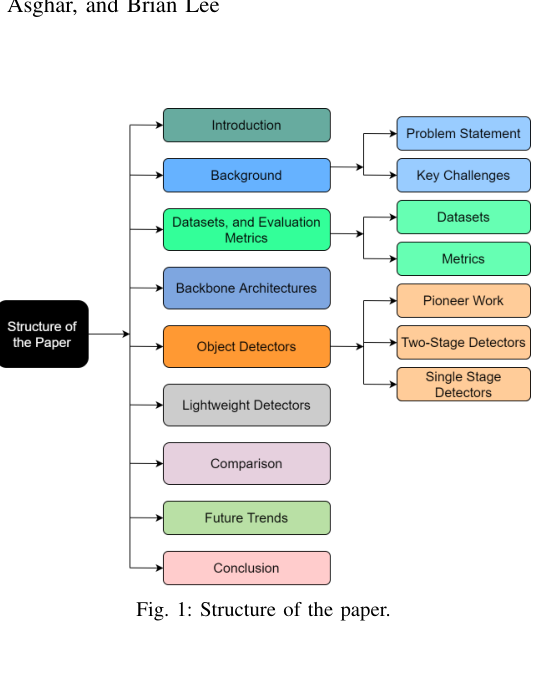

In [12]:
display(cropped_img)